In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix
)

LOADING & PREPROCESSING DATASET

In [27]:
# Load dataset 
df = pd.read_excel('drebin215dataset5560malware9476benign1.xlsx')  # Replace with your dataset path

# Drop rows with missing values
df = df.dropna()


In [28]:
print(df.head())

   ANDROID_OS_BINDER  SEND_SMS  READ_PHONE_STATE  READ_SMS  WRITE_SMS  \
0                  0         1                 1         0          0   
1                  0         1                 1         1          0   
2                  0         1                 1         0          0   
3                  0         0                 1         1          1   
4                  0         0                 1         0          0   

   ACCESS_LOCATION_EXTRA_COMMANDS  ACCESS_NETWORK_STATE  \
0                               0                     0   
1                               0                     0   
2                               0                     1   
3                               1                     1   
4                               0                     1   

   ACCESS_COARSE_LOCATION  ACCESS_WIFI_STATE  WRITE_EXTERNAL_STORAGE  \
0                       0                  0                       1   
1                       0                  0                  

In [29]:
df['CLASS'] = df['CLASS'].apply(lambda x: 1 if x == 'S' else 0)

CHECKING FEATURE IMPORTANCE

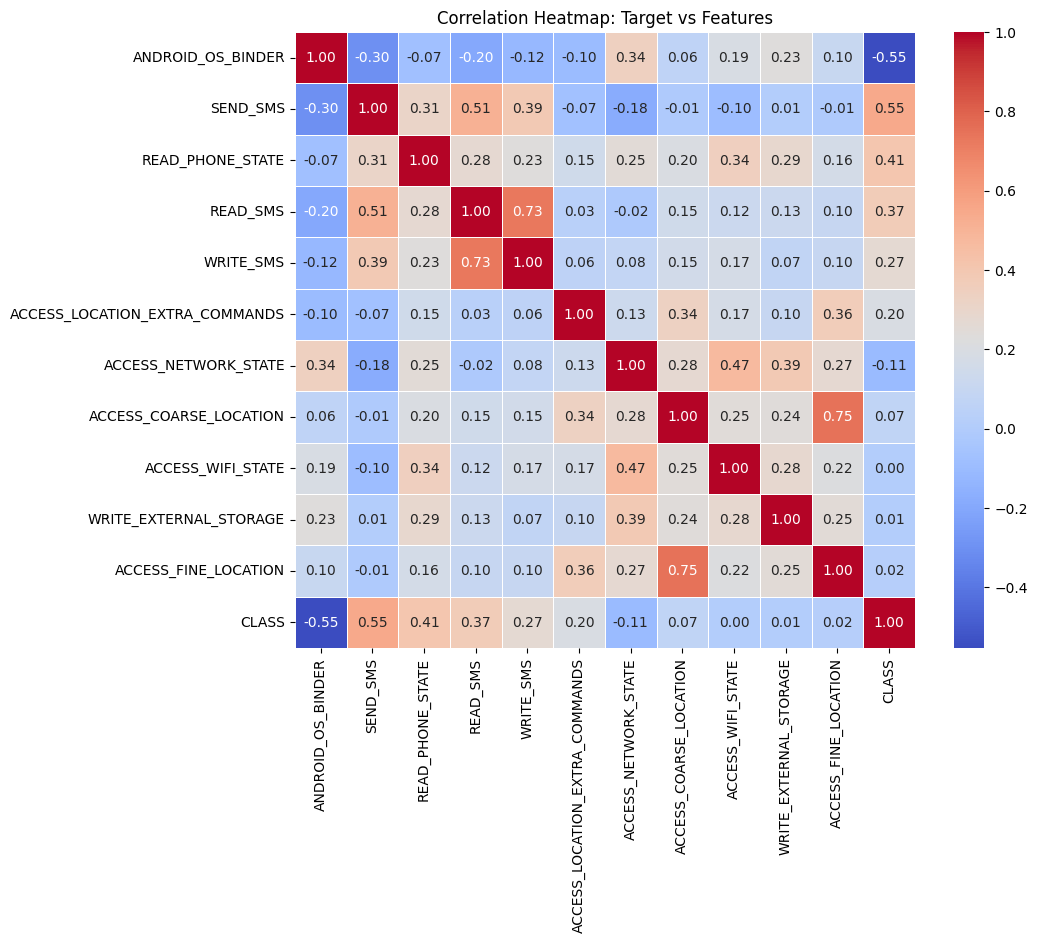

In [30]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

# Add title and display the plot
plt.title('Correlation Heatmap: Target vs Features')
plt.show()

DEVELOPING AND TRAINING THE MODEL

In [31]:
# Feature Scaling (Recommended for Gradient Boosting models)
scaler = StandardScaler()
X = df.drop('CLASS', axis=1)
X_scaled = scaler.fit_transform(X)
y = df['CLASS'].values


In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier
# Define individual classifiers
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
hgb = HistGradientBoostingClassifier(max_iter=200, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

In [34]:
# Voting Classifier (Soft Voting)
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('hgb', hgb), ('xgb', xgb)], 
    voting='soft'
)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('hgb',
                              HistGradientBoostingClassifier(max_iter=200,
                                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=No...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [35]:
# Make predictions
y_pred = voting_model.predict(X_test)
y_pred_proba = voting_model.predict_proba(X_test)[:, 1]

EVALUATION METRICS

In [36]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [37]:
# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.9078
Precision: 0.8952
Recall: 0.8501
F1-Score: 0.8721
AUC-ROC: 0.9578


In [38]:
# Perform cross-validation (5-fold by default)
cv_scores = cross_val_score(voting_model, X_scaled, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Average cross-validation accuracy:", cv_scores.mean())

Cross-validation scores: [0.91057181 0.90721649 0.89890256 0.91320253 0.90256069]
Average cross-validation accuracy: 0.9064908166406045


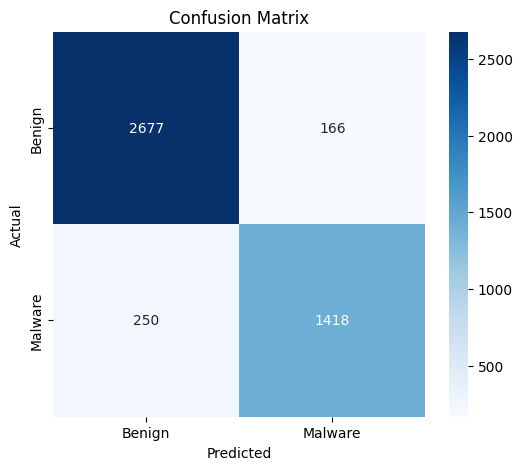

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [40]:
y_pred_proba = voting_model.predict_proba(X_test)[:, 1] 
# 4. AUC-ROC (for binary classification)
if len(set(y_test)) == 2:  # Check if it's binary classification
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC-ROC:", roc_auc)

AUC-ROC: 0.9578167926439712


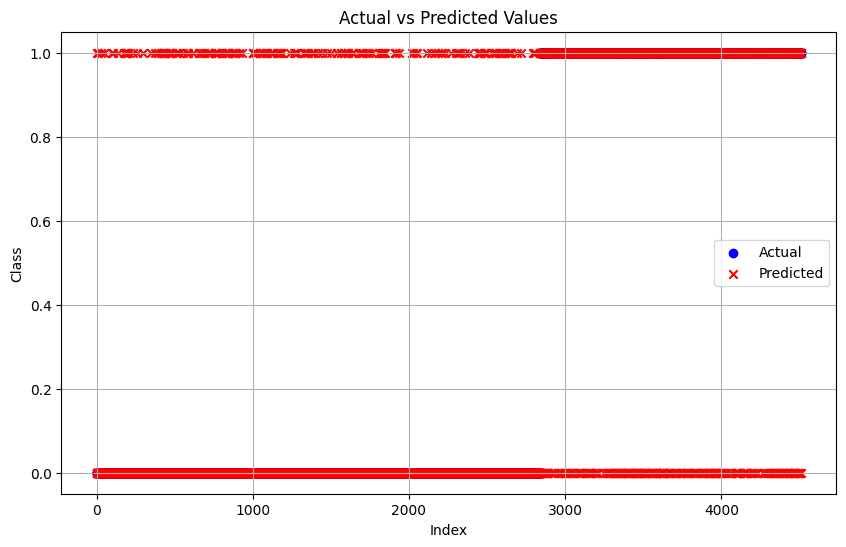

In [41]:
# Sorting values for better visualization
y_test_sorted = np.array(y_test)
y_pred_sorted = np.array(y_pred)
indices = np.argsort(y_test_sorted)
y_test_sorted = y_test_sorted[indices]
y_pred_sorted = y_pred_sorted[indices]

# Plotting discrete points
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_sorted)), y_test_sorted, label="Actual", color="blue", marker="o")
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", color="red", marker="x")

# Add labels and legend
plt.title("Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Class")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Hyperparameter Tuning
param_dist = {
    'hgb__max_iter': [100, 200, 300],  
    'gb__n_estimators': [50, 100, 200],  
    'rf__n_estimators': [50, 100, 200],  
    'rf__max_depth': [None, 10, 20],  
    'gb__learning_rate': [0.01, 0.1, 0.2],  
}

random_search = RandomizedSearchCV(
    estimator=voting_model, 
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,  
    n_jobs=-1,  
    verbose=1,
    random_state=42
)

# Fit Hyperparameter Search
random_search.fit(X_train, y_train)

# Display Best Parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the Best Model
best_model = random_search.best_estimator_
print("Best Model Accuracy on Test Set:", best_model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'rf__n_estimators': 200, 'rf__max_depth': 20, 'hgb__max_iter': 200, 'gb__n_estimators': 200, 'gb__learning_rate': 0.1}
Best Model Accuracy on Test Set: 0.9066725781423188


In [43]:
import numpy as np

# Convert numerical labels to 'Benign' or 'Malware'
label_mapping = {0: "Benign", 1: "Malware"}

# Select a Malware sample from X_test
malware_indices = np.where(y_test == 1)[0]  # Find indices where class is 1 (Malware)
benign_indices = np.where(y_test == 0)[0]  # Find indices where class is 0 (Benign)

# Ensure we have samples to test
if len(malware_indices) > 0:
    malware_sample_idx = np.random.choice(malware_indices)
    malware_input = X_test[malware_sample_idx]
    actual_malware_label = y_test[malware_sample_idx]
    predicted_malware_label = voting_model.predict([malware_input])[0]

    # Convert labels to readable format
    actual_malware_str = label_mapping[actual_malware_label]
    predicted_malware_str = label_mapping[predicted_malware_label]

    # Print Malware sample result
    print("Malware Sample Prediction:")
    print(f"Actual Label: {actual_malware_str}")
    print(f"Predicted Label: {predicted_malware_str}\n")

if len(benign_indices) > 0:
    benign_sample_idx = np.random.choice(benign_indices)
    benign_input = X_test[benign_sample_idx]
    actual_benign_label = y_test[benign_sample_idx]
    predicted_benign_label = voting_model.predict([benign_input])[0]

    # Convert labels to readable format
    actual_benign_str = label_mapping[actual_benign_label]
    predicted_benign_str = label_mapping[predicted_benign_label]

    # Print Benign sample result
    print("Benign Sample Prediction:")
    print(f"Actual Label: {actual_benign_str}")
    print(f"Predicted Label: {predicted_benign_str}")


Malware Sample Prediction:
Actual Label: Malware
Predicted Label: Malware

Benign Sample Prediction:
Actual Label: Benign
Predicted Label: Benign


In [ ]:
# import pandas as pd

# # Load the new APK feature dataset (replace 'apk_features.xlsx' with your actual file)
# apk_data = pd.read_excel("apk_features.xlsx")

# # Load the feature names used in the trained model (assuming X_train was a DataFrame)
# relevant_features = X_train.columns  # Ensure this comes from your training data

# # Extract only the relevant features from the new dataset
# apk_data_filtered = apk_data[relevant_features]

# # Predict using the trained model
# apk_predictions = voting_model.predict(apk_data_filtered)

# # Display predictions
# apk_data_filtered["Predicted_Label"] = apk_predictions
# print(apk_data_filtered[["Predicted_Label"]].head())  # Show first few predictions

# # Save results to a new Excel file
# apk_data_filtered.to_excel("apk_predictions.xlsx", index=False)
# print("Predictions saved to apk_predictions.xlsx")


In [1]:
# import os
# import json
# import csv
# from androguard.misc import AnalyzeAPK
# import pandas as pd
# import joblib  # Assuming the trained model is saved as a .pkl file

# # # Load the trained model
# # model = joblib.load("malware_detection_model.pkl")

# # Define the features used in training
# dataset_features = ["ANDROID_OS_BINDER", "SEND_SMS", "READ_PHONE_STATE", "READ_SMS", "WRITE_SMS", 
#                      "ACCESS_LOCATION_EXTRA_COMMANDS", "ACCESS_NETWORK_STATE", "ACCESS_COARSE_LOCATION", 
#                      "ACCESS_WIFI_STATE", "WRITE_EXTERNAL_STORAGE", "ACCESS_FINE_LOCATION"]

# def analyze_apk(apk_path):
#     apk_info, dex_code, analysis = AnalyzeAPK(apk_path)

#     permissions = apk_info.get_permissions() or []
#     feature_dict = {feature: 0 for feature in dataset_features}
    
#     for permission in permissions:
#         feature_name = permission.split(".")[-1]  # Extract permission name
#         if feature_name in feature_dict:
#             feature_dict[feature_name] = 1
    
#     return pd.DataFrame([feature_dict])

# def predict_apk(apk_path):
#     features_df = analyze_apk(apk_path)
#     if features_df is None:
#         return "Error extracting features."
    
#     # Ensure correct feature order
#     features_df = features_df[dataset_features]
    
#     # Predict
#     prediction = voting_model.predict(features_df)
#     return "Malware" if prediction[0] == 1 else "Benign"

# # Jupyter Notebook Cell Execution
# apk_path = "C:\\Users\\KRISHA\\OneDrive - National Institute of Technology Karnataka, Surathkal\\Documents\\ASAN FREELANCING\\Malware Detection\\Python Notebooks\\apks\\0000BAB3BFF0BBE9CD293154BC1CCEC03D2CF92D29E89CC7F365B6CBCFDB6DB8.apk"

# if os.path.exists(apk_path):
#     result = predict_apk(apk_path)
#     print(f"Prediction for {apk_path}: {result}")
# else:
#     print(f"Error: APK file '{apk_path}' not found.")
